In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [2]:
data_path = "C:\\Sowmya\\Personal\\PYTORCH\\Pytorch_stuffs\\BERT\\Multi Class Text Classification\\twitter.csv"

col = ['Tweet ID', 'entity', 'sentiment', 'Tweet content']
df = pd.read_csv(data_path, names=col)
df.head()

,Tweet ID,entity,sentiment,Tweet content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [3]:
df.isnull().sum()

Tweet ID         0
entity           0
sentiment        0
Tweet content    0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       1000 non-null   int64 
 1   entity         1000 non-null   object
 2   sentiment      1000 non-null   object
 3   Tweet content  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [5]:
df = df.drop(['Tweet ID', 'entity'], axis=1)
df.head()

,sentiment,Tweet content
0,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Negative,@Microsoft Why do I pay for WORD when it funct...
3,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,Neutral,Now the President is slapping Americans in the...


In [6]:
df.sentiment.unique()

array(['Irrelevant', 'Neutral', 'Negative', 'Positive'], dtype=object)

In [7]:
sentiment_mapping = {
    'Irrelevant': 0,
    'Neutral': 1,
    'Negative': 2,
    'Positive': 3
}

In [8]:
df['sentiment'] = df['sentiment'].map(sentiment_mapping)

df.head()

,sentiment,Tweet content
0,0,I mentioned on Facebook that I was struggling ...
1,1,BBC News - Amazon boss Jeff Bezos rejects clai...
2,2,@Microsoft Why do I pay for WORD when it funct...
3,2,"CSGO matchmaking is so full of closet hacking,..."
4,1,Now the President is slapping Americans in the...


In [9]:
df.sentiment.value_counts()

sentiment
1    285
3    277
2    266
0    172
Name: count, dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

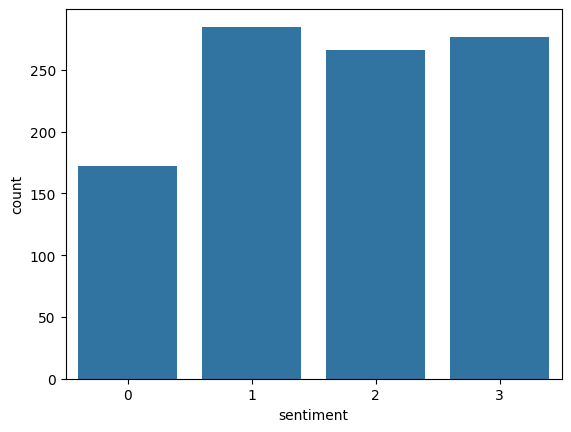

In [10]:
sns.countplot(df, x=df['sentiment'])

In [47]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import transformers
from transformers import BertTokenizer, BertModel
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

In [12]:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 5

In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

c:\Users\2260927\Anaconda3\envs\deeplearning\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
class BERTDataset:
    def __init__(self, tweets, sentiments, tokenizer, max_len):
        self.tweets = tweets
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, item):
        tweets = str(self.tweets[item])
        tweets = " ".join(tweets.split())

        encoding = self.tokenizer.encode_plus(
            tweets,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            "tweets": tweets,
            "input_ids": encoding['input_ids'].flatten(),
            "attention_mask": encoding['attention_mask'].flatten(),
            "targets": torch.tensor(self.sentiments[item], dtype=torch.long)
        }

In [15]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [16]:
len(train_df), len(val_df), len(test_df)

(800, 100, 100)

In [17]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = BERTDataset(
        tweets = df['Tweet content'].values,
        sentiments= df['sentiment'].values,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=0
    ) 

In [18]:
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_Data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [19]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweets', 'input_ids', 'attention_mask', 'targets'])

In [20]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Sentiment classification with BERT and Hugging face

In [21]:

encoding = tokenizer.encode_plus(
    df['Tweet content'][0],
    add_special_tokens=True,
    max_length=MAX_LEN,
    pad_to_max_length=True,
    return_attention_mask=True,
    truncation=True,
    return_token_type_ids=False,
    return_tensors='pt',
)

encoding.keys()

c:\Users\2260927\Anaconda3\envs\deeplearning\lib\site-packages\transformers\tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [22]:
print(len(encoding['input_ids'][0]))
encoding['input_ids']

160


tensor([[  101,  1045,  3855,  2006,  9130,  2008,  1045,  2001,  8084,  2005,
         14354,  2000,  2175,  2005,  1037,  2448,  1996,  2060,  2154,  1010,
          2029,  2038,  2042,  5421,  2011,  3419,  1521,  1055,  2307,  5916,
          2666,  2004,  1520, 10974,  3051,  2064,  1521,  1056,  2131,  2041,
          1997,  2793,  1521,  1998,  2409,  2000,  2010, 13055,  1010,  2040,
          2085,  6732,  1045,  1521,  1049,  1037, 13971,  1010,  6659,  2711,
           100,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [23]:
bert_model = BertModel.from_pretrained("bert-base-uncased")

In [24]:
outputs = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
)

In [25]:
outputs.last_hidden_state.shape

# 1 -> no of records
# 160  -> length of our sequence
# 768  -> hidden units in the feedforward networds

torch.Size([1, 160, 768])

In [26]:
outputs.pooler_output.shape

torch.Size([1, 768])

In [27]:
bert_model.config.hidden_size

768

# Building a sentiment classifier

In [28]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(p=0.3)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask
            )
        
        out_dropout = self.dropout(outputs.pooler_output)
        output = self.linear(out_dropout)
        return self.softmax(output)

In [29]:
device = torch("cuda") if torch.cuda.is_available() else "cpu"
device

'cpu'

In [30]:
model = SentimentClassifier(n_classes=4)
model.to(device)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [31]:
input_ids = data['input_ids']
attention_mask = data['attention_mask']

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 160])
torch.Size([16, 160])


In [32]:
model(input_ids, attention_mask)

tensor([[0.1727, 0.2087, 0.3158, 0.3028],
        [0.1454, 0.2194, 0.2324, 0.4028],
        [0.1708, 0.2726, 0.2384, 0.3183],
        [0.2721, 0.2685, 0.1512, 0.3081],
        [0.1736, 0.4897, 0.1128, 0.2239],
        [0.1709, 0.2570, 0.3101, 0.2620],
        [0.1628, 0.3340, 0.2353, 0.2680],
        [0.3076, 0.2600, 0.2153, 0.2171],
        [0.2330, 0.2205, 0.2069, 0.3397],
        [0.2311, 0.1264, 0.2943, 0.3481],
        [0.1739, 0.2404, 0.2356, 0.3501],
        [0.1942, 0.3440, 0.2140, 0.2479],
        [0.1575, 0.2734, 0.1749, 0.3941],
        [0.1930, 0.1850, 0.3492, 0.2727],
        [0.2255, 0.2216, 0.2611, 0.2918],
        [0.1357, 0.2994, 0.2044, 0.3605]], grad_fn=<SoftmaxBackward0>)

# Training

In [33]:
EPOCHS = 10

optimizer = AdamW(params=model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

c:\Users\2260927\Anaconda3\envs\deeplearning\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [34]:
def train_epoch(
        model,
        data_loader,
        optimizer,
        loss_fn,
        scheduler,
        device,
        n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)
        

In [35]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask
            )

            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(targets == preds)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [36]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        loss_fn,
        scheduler,
        device,
        len(train_df)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    val_acc, val_loss = eval_model(
        model,
        val_Data_loader,
        loss_fn,
        device,
        n_examples=len(val_df)
    )

    print(f"Val loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.3483243656158448 accuracy 0.35625
Val loss 1.3684299673352922 accuracy 0.27

Epoch 2/10
----------
Train loss 1.2316862320899964 accuracy 0.51
Val loss 1.2358984691756112 accuracy 0.56

Epoch 3/10
----------
Train loss 1.112964961528778 accuracy 0.63125
Val loss 1.222815956388201 accuracy 0.52

Epoch 4/10
----------
Train loss 1.0346218347549438 accuracy 0.70625
Val loss 1.207271592957633 accuracy 0.55

Epoch 5/10
----------
Train loss 0.9849189877510071 accuracy 0.75375
Val loss 1.2399457693099976 accuracy 0.46

Epoch 6/10
----------
Train loss 0.9431527280807495 accuracy 0.80625
Val loss 1.2692315067563738 accuracy 0.47

Epoch 7/10
----------
Train loss 0.9032458627223968 accuracy 0.85
Val loss 1.3310644456318446 accuracy 0.38

Epoch 8/10
----------
Train loss 0.8705000245571136 accuracy 0.88375
Val loss 1.3436403104237147 accuracy 0.39

Epoch 9/10
----------
Train loss 0.8503233695030212 accuracy 0.90125
Val loss 1.3432529313223702 accuracy 0.41

E

(0.0, 1.0)

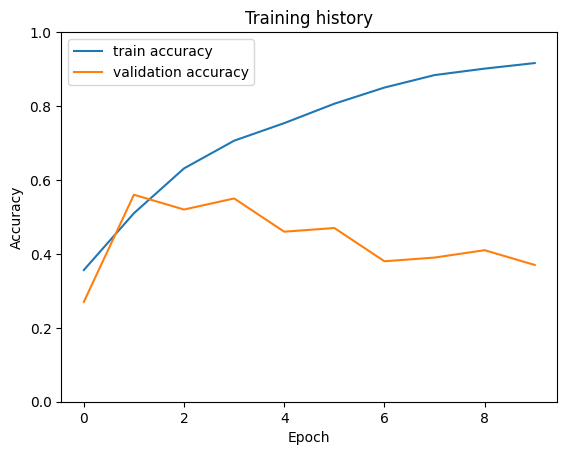

In [39]:
import matplotlib.pyplot as plt

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title("Training history")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.ylim([0, 1])

# Evaluation

In [40]:
test_acc, _ = eval_model(
    model,
    test_data_loader, 
    loss_fn,
    device,
    n_examples=len(test_df)
)

test_acc.item()

0.53

In [41]:
def get_predictions(model, data_loader):
    model = model.eval()

    tweet_text = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d['tweets']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(input_ids, attention_mask)

            _, preds = torch.max(outputs, dim=1)

            tweet_text.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return tweet_text, predictions, prediction_probs, real_values
    

In [42]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [52]:
len(y_tweet_texts), len(test_df)

(100, 100)

In [44]:
target_names = ['Irrelevant', 'Neutral', 'Negative', 'Positive']
target_names

['Irrelevant', 'Neutral', 'Negative', 'Positive']

In [46]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Irrelevant       0.19      0.43      0.27        14
     Neutral       0.50      0.33      0.40        24
    Negative       0.75      0.67      0.71        27
    Positive       0.72      0.60      0.66        35

    accuracy                           0.53       100
   macro avg       0.54      0.51      0.51       100
weighted avg       0.60      0.53      0.55       100



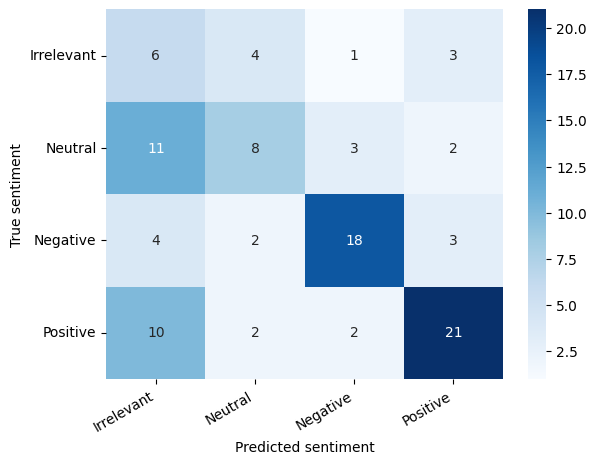

In [50]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)
show_confusion_matrix(df_cm)

In [57]:
idx = 2

tweet_text = y_tweet_texts[idx]
true_sentiment = y_test[idx]

pred_df = pd.DataFrame({
    'target_names': target_names,
    'values': y_pred_probs[idx]
})

In [59]:
print(tweet_text)
print()
print(f"True sentiment: {target_names[true_sentiment]}")

we've been crushing CS:GO over at @windailysports ! Congrats @jack94024127 💪🏻

True sentiment: Positive


In [60]:
pred_df

,target_names,values
0,Irrelevant,0.775229
1,Neutral,0.213476
2,Negative,0.009891
3,Positive,0.001404


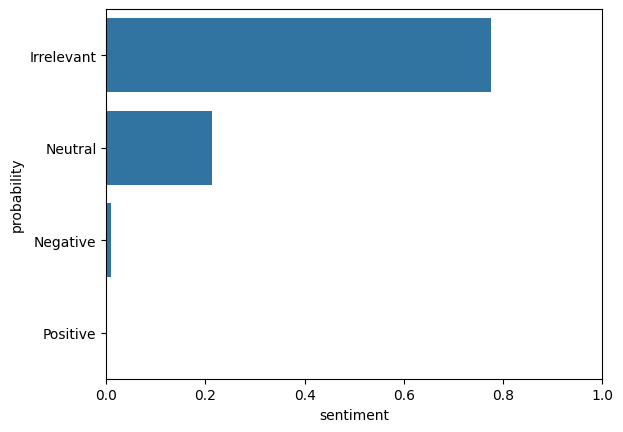

In [63]:
sns.barplot(x='values', y='target_names', data=pred_df, orient='h')
plt.xlabel('sentiment')
plt.ylabel('probability')
plt.xlim([0, 1]);

# Predicting on Raw text

In [64]:
tweet_text = 'I love completing my todos! Best app ever!!!'

In [65]:
encoded_tweet = tokenizer.encode_plus(
    tweet_text,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)

In [66]:
input_ids = encoded_tweet["input_ids"].to(device)
attention_mask = encoded_tweet["attention_mask"].to(device)

output = model(input_ids, attention_mask)

_, prediction = torch.max(output, dim=1)

print(f"Tweet text: {tweet_text}")
print(f"Sentiment: {target_names[prediction]}")

Tweet text: I love completing my todos! Best app ever!!!
Sentiment: Positive
